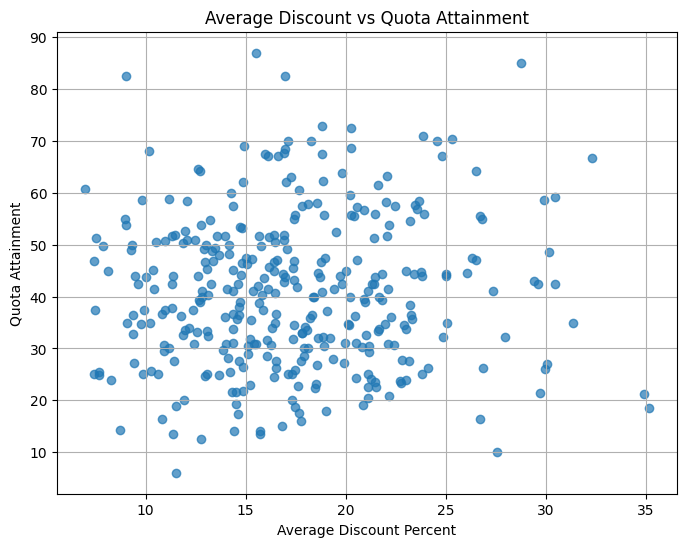

The correlation between averageSavingsPercent and quota_attainment is: 0.04413591805153201
Total deals evaluated: 43686
Average quota attainment: 40.83676128538557
Mean quota attainment for averageSavingsPercent > 25: 42.37172413793103
Mean quota attainment for averageSavingsPercent <= 25: 40.695492063492054
Mean quota attainment for averageSavingsPercent <= 10: 41.091538461538455


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./repvue_quota_attainment_clean.csv')
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['averageSavingsPercent'], df['quota_attainment'], alpha=0.7)
plt.title('Average Discount vs Quota Attainment')
plt.xlabel('Average Discount Percent')
plt.ylabel('Quota Attainment')
plt.grid(True)
plt.show()

# Compute the correlation between averageSavingsPercent and quota_attainment
df['averageSavingsPercent'] = pd.to_numeric(df['averageSavingsPercent'], errors='coerce')
df['quota_attainment'] = pd.to_numeric(df['quota_attainment'], errors='coerce')

correlation = df['averageSavingsPercent'].corr(df['quota_attainment'])

print(f"The correlation between averageSavingsPercent and quota_attainment is: {correlation}")

total_negotiations_handled = df['negotiationsHandled'].sum()
average_quota_attainment = df['quota_attainment'].mean()

print(f"Total deals evaluated: {total_negotiations_handled}")
print(f"Average quota attainment: {average_quota_attainment}")

df['quota_attainment'] = df['quota_attainment'].round(2)

# Filter rows where averageSavingsPercent > 25
high_savings = df[df['averageSavingsPercent'] > 25]

# Compute the mean quota attainment for these rows
mean_quota_high_savings = high_savings['quota_attainment'].mean()

# Filter rows where averageSavingsPercent <= 25
low_savings = df[df['averageSavingsPercent'] <= 25]

# Compute the mean quota attainment for these rows
mean_quota_low_savings = low_savings['quota_attainment'].mean()

# Filter rows where averageSavingsPercent <= 25
very_low_savings = df[df['averageSavingsPercent'] <= 10]

# Compute the mean quota attainment for these rows
mean_quota_very_low_savings = very_low_savings['quota_attainment'].mean()

print(f"Mean quota attainment for averageSavingsPercent > 25: {mean_quota_high_savings}")
print(f"Mean quota attainment for averageSavingsPercent <= 25: {mean_quota_low_savings}")
print(f"Mean quota attainment for averageSavingsPercent <= 10: {mean_quota_very_low_savings}")

df.to_csv('li_post.csv', columns=['quota_attainment', 'averageSavingsPercent'])


In [26]:
import pandas as pd
import requests
import http
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Function to scrape RepVue data
def scrape_repvue_url(company_slug):
    url = f'https://www.repvue.com/_next/data/3GERlKV7GdRpNvv56AOwc/en/companies/{company_slug}.json?slug={company_slug}'
    try:
        headers = {
            'accept': '*/*',
            'accept-language': 'en-US,en;q=0.9',
            'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
            'Cookie': '_ga=GA1.1.853467562.1736252391; _tt_enable_cookie=1; _ttp=5k1XfHPKuVvtYJcFR-9HArfCftT.tt.1; repvue_consent=true; _ga_20BBWGRF3X=GS1.1.1736858245.4.0.1736858249.0.0.0; mp_dc14bdafdff673e2452bc261c4fdc3ae_mixpanel=%7B%22distinct_id%22%3A%20%22%24device%3A19440b4fce0136-031dfe1dce22bf-1e525636-201b88-19440b4fce0136%22%2C%22%24device_id%22%3A%20%2219440b4fce0136-031dfe1dce22bf-1e525636-201b88-19440b4fce0136%22%2C%22%24search_engine%22%3A%20%22google%22%2C%22%24initial_referrer%22%3A%20%22https%3A%2F%2Fwww.google.com%2F%22%2C%22%24initial_referring_domain%22%3A%20%22www.google.com%22%2C%22__mps%22%3A%20%7B%7D%2C%22__mpso%22%3A%20%7B%22%24initial_referrer%22%3A%20%22https%3A%2F%2Fwww.google.com%2F%22%2C%22%24initial_referring_domain%22%3A%20%22www.google.com%22%7D%2C%22__mpus%22%3A%20%7B%7D%2C%22__mpa%22%3A%20%7B%7D%2C%22__mpu%22%3A%20%7B%7D%2C%22__mpr%22%3A%20%5B%5D%2C%22__mpap%22%3A%20%5B%5D%7D'
        }
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            data = response.json()
            company = data.get('pageProps', {}).get('company', {})
            # overview = data.get('pageProps', {}).get('overview', {})
            # quota_attainment = company.get('quota_attainment', None)
            # industry_average_quota_attainment = overview.get('industry_average_quota_attainment', None)
            total_reviews = company.get('ratings_count', 0)

            total_verified_reviews = company.get('ratings_count', 0) *  company.get('verified_ratings_percent', 100)/100
            return total_reviews, total_verified_reviews
        else:
            print(response)
            return None, None
    except Exception as e:
        print(f"Error in scrape_repvue_url for {url}: {e}")
        return None, None

# Combined function to process each row
def process_row(row):
    try:
        repvue_slug = row['repvue_slug']
        if repvue_slug:
            total_reviews, total_verified_reviews = scrape_repvue_url(repvue_slug)
            return row['index'], total_reviews, total_verified_reviews
        return row['index'], None, None
    except Exception as e:
        print(f"Error in process_row for {row['company_name']}: {e}")
        return row['index'], None, None

# Load the dataframe
df = pd.read_csv('./repvue_quota_attainment_clean.csv')
df = df[['repvue_slug']]

# Add index to rows for tracking
df.reset_index(inplace=True)

df['total_reviews'] = None
df['total_verified_reviews'] = None
# Process rows in parallel
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    # Submit tasks
    futures = {executor.submit(process_row, row): row for _, row in df.iterrows()}
    
    # Track progress with tqdm
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Rows"):
        try:
            results.append(future.result())
        except Exception as e:
            print(f"Error while processing a future: {e}")

# Update dataframe with results
for index, total_reviews, total_verified_reviews in results:
    df.at[index, 'total_reviews'] = total_reviews
    df.at[index, 'total_verified_reviews'] = round(total_verified_reviews)
    # df.at[index, 'industry_average_quota_attainment'] = industry_average
    # df.at[index, 'repvue_slug'] = repvue_slug

total_reviews = df['total_verified_reviews'].sum()
print(f"Total reviews: {total_reviews}")


Processing Rows: 100%|██████████| 344/344 [00:03<00:00, 91.04it/s] 

Total reviews: 65308
